<a href="https://colab.research.google.com/github/arnaudsaulou/CEWP_MOD3_2194_GRA_CsicoPacketTracerProject/blob/master/Project_Connect4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Alpha Go

You have probably heard of Alpha Go, the program which beat Lee Sedol, the world champion of Go, in March 2016.



In [ ]:
from IPython.display import HTML
HTML('<iframe width="1855" height="983" src="https://www.youtube.com/embed/WXuK6gekU1Y" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

After that, Alpha go was improved: 
- in December 2017, Alpha Zero learnt to play from scratch, by millions of games against itself, using only the rules of the game, and was reused also for Chess and Shogi.
- in November 2019, MuZero did even better: it does not know the full rules of the game. In some way, it also learns the rules, because the game engine tells it when a move was illegal.

![texte du lien](https://miro.medium.com/max/601/1*ROq9V2D5eR_dDFFFfjA5zw.png)

Have a look [here](https://medium.com/applied-data-science/how-to-build-your-own-muzero-in-python-f77d5718061a) for more information.

In this project, you will train a neural network to play Connect4, similarly to Alpha Zero. The game being simpler, you won't need huge computer resources to train your algorithm. Note that this notebook is a complete revamping of [that one](https://medium.com/applied-data-science/how-to-build-your-own-alphazero-ai-using-python-and-keras-7f664945c188).

#Game rules: 2 points
The state of the game is stored into the object GameState.
- currentPlayer is either 1 (PLAYER_1) or -1 (PLAYER_2). Changing players is easy: you simply have to multiply currentPlayer by -1.
- board is a 6x7 numpy array, containing 0 (no token), 1 (token of PLAYER_1) or -1 (token of PLAYER_2). Warning: it is reversed, see below.
- id is a representation of the game state as a big integer. We need this in the Monte Carlo Tree Search, because game states are stored as integers in order to save memory space, and because we want to avoid storing duplicates: the id is a unique representation of the game state. The function ```_generate_id()``` generates the id corresponding to the game state, and the function ```from_id(id)``` generates the gameState corresponding to the id.

At the beginning of the game, the board contains only 0, and its string representation is
```
['-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-']
```

Players can chose an action between 0 (leftmost) and 6 (rightmost). If Player_1 plays first and choses action 2, the board is now:

```
[0, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0]
```
And its string representation:
```
['-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-']
['-', '-', 'X', '-', '-', '-', '-']
```
Then, if player_2 choses action 6, the board is now:
```
[0, 0, 1, 0, 0, 0, -1]
[0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0]
```
And its string representation:
```
['-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-']
['-', '-', 'X', '-', '-', '-', 'O']
```
Then, if player_1 choses action 6, the board is now:
```
[0, 0, 1, 0, 0, 0, -1]
[0, 0, 0, 0, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0]
```
And its string representation:
```
['-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', 'X']
['-', '-', 'X', '-', '-', '-', 'O']




In [ ]:

GRID_SHAPE = (6,7)

PLAYER_1	= 1
NONE		= 0
PLAYER_2	= -1
RENDER_PLAYERS = {PLAYER_1:'X', NONE: '-', PLAYER_2:'O'}

NB_TOKENS_VICTORY = 4

# 0 and 1 are the only possible values, due to the way the neural network is working (it predicts a sigmoid)
VALUE_DEFAULT_ACTION = 0
VALUE_VICTORY = 1 

In [ ]:
import numpy as np
import functools

In [ ]:

class GameState():

	def __init__(self, currentPlayer, grid_shape = GRID_SHAPE, board=None):

		self.currentPlayer = currentPlayer
		if board is not None:
			self.board = board
		else:
			self.board = np.full(grid_shape, NONE, dtype=np.int8)
		self.id = self._generate_id()

	def generate_symetric_state(self):

		"""Trick: in order to improve the learning speed of the neural network, we store in memory the state
		# of the game AND its symetric."""
		
		# YOUR CODE HERE: generate a new instance of GameState, with the same current player and the symetric of the board,
		# along the 3rd column.
		# For example, if the board of the game state is:
		# [0, 0, 1, 0, 0, 0, -1]
		# [0, 0, 0, 0, 0, 0, 0]
		# [0, 0, 0, 0, 0, 0, 0]
		# [0, 0, 0, 0, 0, 0, 0]
		# [0, 0, 0, 0, 0, 0, 0]
		# [0, 0, 0, 0, 0, 0, 0]
		# Then its symetric is:
		# [-1, 0, 0, 0, 1, 0, 0]
		# [0, 0, 0, 0, 0, 0, 0]
		# [0, 0, 0, 0, 0, 0, 0]
		# [0, 0, 0, 0, 0, 0, 0]
		# [0, 0, 0, 0, 0, 0, 0]
		# [0, 0, 0, 0, 0, 0, 0]
		return symetric_game_state


	def get_board_for_neural_network(self):
		""" If it is PLAYER_2 turn, we inverse the point of view.
		That way, the neural network is always player 1 and its opponent is always player -1
		=> The neural network can play against itself, instead of needing another neural network as opponent."""
		result = self.board * self.currentPlayer

		return result

		

	def allowedActions(self):
		"""Returns one boolean per possible action. 
		Example: [True, True, False, True, True, True, True] if action number 2 is not allowed.
		An action is not allowed when the corresponding column is full.
		"""
		# TODO Your code here: allowed_actions must be an array of size 7 (number of possible actions),
		# and it should return one boolean per possible action, telling if that action is allowed or not
		return allowed_actions

	def checkForEndGame(self):
		"""Returns true if no action is possible (ie. if the board is full)"""
		"""Does NOT check for victory of the players"""
		# TODO Your code here
		return result

	def takeAction(self, action):
		"""action must be between 0 (leftmost) and 6 (rightmost, ie. grid_shape[1]-1)"""
		"""Computes (newState, value, done)"""
		"""newState: GameState representing the state of the game after the current player has taken action"""
		"""value: reward for that action"""
		"""done: 1 if end of the game, 0 otherwise"""

		# YOUR CODE HERE: currentPlayer plays the action 'action'
		# next_state: new instance of GameState, with the new currentPlayer, and the new board
		# value: -VALUE_VICTORY if currentPlayer has won, else VALUE_DEFAULT_ACTION
		# done: True if the game is finished, ie. if currentPlayer has won, or if no action is possible

		# -value instead of value because this function outputs the value of the new state (ie. next_state)
		# from the point of vue (POV) of the new player (ie. of the player who will play after the current one)
		return (next_state, -value, done) 

	def _generate_id(self):
		"""Computes a unique id for that state (another identical state will have the same id)"""
		"""The id is as small as possible for saving memory space (even so, it is a 85-bits integer)"""

		board_as_line = np.reshape(self.board, -1)
		player1_line = (board_as_line == PLAYER_1)
		player2_line = (board_as_line == PLAYER_2)
		result_line = np.concatenate((player1_line,player2_line,[self.currentPlayer==PLAYER_1])).tolist()
		# See https://stackoverflow.com/questions/25583312/changing-an-array-of-true-and-false-answers-to-a-hex-value-python
		result_line_val = functools.reduce(lambda byte, bit: byte*2 + bit, result_line, 0)
		return result_line_val

	@staticmethod
	def from_id(id, grid_shape):
		"""Generates a GameState from id"""

		# See https://stackoverflow.com/questions/33608280/convert-4-bit-integer-into-boolean-list/33608387
		nb_booleans = grid_shape[0] * grid_shape[1] * 2 + 1		
		full_state = np.flip(np.array([bool(id & (1<<n)) for n in range(nb_booleans)]))
		player1_board = full_state[:grid_shape[0] * grid_shape[1]].reshape(grid_shape[0], grid_shape[1])
		player2_board = full_state[grid_shape[0] * grid_shape[1]:-1].reshape(grid_shape[0], grid_shape[1])
		current_player = full_state[-1]

		board = player1_board * PLAYER_1 + player2_board * PLAYER_2
		current_player = PLAYER_1 if current_player else PLAYER_2

		result = GameState(current_player, board=board.astype(np.int8))
		return result

	@staticmethod
	def current_player_from_id(id):

		current_player = bool(id & (1<<0))
		current_player = PLAYER_1 if current_player else PLAYER_2
		return current_player


	def _isVictory(self, latestAction, currentPlayer):
		"""Returns True if latestAction led currentPlayer to victory"""
		# YOUR CODE HERE: True if the latest action of currentPlayer could align NB_TOKENS_VICTORY
		# horizontally, vertically or in diagonal
		
		return False


	def __repr__(self):
		"""String representation of the GameState object."""
		result=''
		for r in reversed(range(self.board.shape[0])):
			result = result + str([RENDER_PLAYERS[x] for x in self.board[r]]) + '\n'

		return result

In [ ]:

class Game:

	def __init__(self, grid_shape = GRID_SHAPE):		
		self.grid_shape = grid_shape
		self.name = 'connect4'
		self.action_size = grid_shape[1]
		self.reset()

	def reset(self):
		self.gameState = GameState(grid_shape = self.grid_shape, currentPlayer = PLAYER_1)
		return self.gameState


	def step(self,action):
		next_state, value, done = self.gameState.takeAction(action)
		# updates current game state
		self.gameState = next_state

		return (next_state, value, done)



In [ ]:
env = Game()
env.reset()

['-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-']

In [ ]:
next_state, value, done = env.step(3)

assert(done == False)
assert(value == 0)
assert(np.array_equal(next_state.board, np.array([[0, 0, 0, 1, 0, 0, 0], 
                                           [0, 0, 0, 0, 0, 0, 0], 
                                           [0, 0, 0, 0, 0, 0, 0], 
                                           [0, 0, 0, 0, 0, 0, 0], 
                                           [0, 0, 0, 0, 0, 0, 0], 
                                           [0, 0, 0, 0, 0, 0, 0]])))

['-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', 'X', '-', '-', '-']

Value: 0, done: False


In [ ]:
next_state, value, done = env.step(2)

assert(done == False)
assert(value == 0)
assert(np.array_equal(next_state.board, np.array([[0, 0, -1, 1, 0, 0, 0], 
                                           [0, 0, 0, 0, 0, 0, 0], 
                                           [0, 0, 0, 0, 0, 0, 0], 
                                           [0, 0, 0, 0, 0, 0, 0], 
                                           [0, 0, 0, 0, 0, 0, 0], 
                                           [0, 0, 0, 0, 0, 0, 0]])))

['-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-']
['-', '-', 'O', 'X', '-', '-', '-']

Value: 0, done: False


In [ ]:
next_state, value, done = env.step(3)
next_state, value, done = env.step(2)
next_state, value, done = env.step(3)
next_state, value, done = env.step(2)
next_state, value, done = env.step(3)

assert(done == True)
assert(value == -1)
assert(np.array_equal(next_state.board, np.array([[0, 0, -1, 1, 0, 0, 0], 
                                           [0, 0, -1, 1, 0, 0, 0], 
                                           [0, 0, -1, 1, 0, 0, 0], 
                                           [0, 0, 0, 1, 0, 0, 0], 
                                           [0, 0, 0, 0, 0, 0, 0], 
                                           [0, 0, 0, 0, 0, 0, 0]])))

['-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', 'X', '-', '-', '-']
['-', '-', 'O', 'X', '-', '-', '-']
['-', '-', 'O', 'X', '-', '-', '-']
['-', '-', 'O', 'X', '-', '-', '-']

Value: -1, done: True


In [ ]:
# Test of the method game_state._isVictory: horizontal lines

for ligne in range(0,GRID_SHAPE[0]):
    #On met toutes les façons d'aligner 4 PLAYER_1 dans la ligne ligne
    for column in range(0,GRID_SHAPE[1]+1-NB_TOKENS_VICTORY):
        board = np.full(GRID_SHAPE, NONE, dtype=np.int8)
        board[ligne, column:column+NB_TOKENS_VICTORY] = PLAYER_1
        #On remplit les lignes sous ligne avec PLAYER_2
        board[0:ligne,:] = PLAYER_2

        game_state = GameState(grid_shape = GRID_SHAPE, currentPlayer=PLAYER_1, board=board)

        for i in range(column,column+NB_TOKENS_VICTORY):
            is_victory = game_state._isVictory(i, PLAYER_1)
            assert(is_victory == True)

In [ ]:
# Test of the method game_state._isVictory: vertical lines

for ligne in range(0,GRID_SHAPE[0]+1-NB_TOKENS_VICTORY):
    for column in range(0,GRID_SHAPE[1]):
        #On met toutes les façons d'aligner 4 PLAYER_1 dans la colonne column
        board = np.full(GRID_SHAPE, NONE, dtype=np.int8)
        board[ligne:ligne+NB_TOKENS_VICTORY, column] = PLAYER_1
        #On remplit les lignes sous ligne avec PLAYER_2
        board[0:ligne,:] = PLAYER_2
        game_state = GameState(grid_shape = GRID_SHAPE, currentPlayer=PLAYER_1, board=board)

        is_victory = game_state._isVictory(column, PLAYER_1)
        assert(is_victory == True)

In [ ]:
# Test of the method game_state._isVictory: diagonal 1 (bottom left to top right)

for ligne in range(0,GRID_SHAPE[0]+1-NB_TOKENS_VICTORY):
    for column in range(0,GRID_SHAPE[1]+1-NB_TOKENS_VICTORY):
        #On aligne 4 PLAYER_1 dans la diagonale dont le point de départ (bas,gauche) est (ligne,column)
        board = np.full(GRID_SHAPE, NONE, dtype=np.int8)
        for i,j in zip(range(ligne,ligne+NB_TOKENS_VICTORY), range(column, column+NB_TOKENS_VICTORY)):
            board[i,j] = PLAYER_1
            board[0:i,j] = PLAYER_2
            board[i,j+1:] = PLAYER_2
        #On remplit les lignes sous ligne avec PLAYER_2
        board[0:ligne,:] = PLAYER_2
        game_state = GameState(grid_shape = GRID_SHAPE, currentPlayer=PLAYER_1, board=board)

        for i in range(column,column+NB_TOKENS_VICTORY):
            is_victory = game_state._isVictory(i, PLAYER_1)
            assert(is_victory == True)

In [ ]:
# Test of the method game_state._isVictory: diagonal 2 (bottom right to top left)

for ligne in range(GRID_SHAPE[0]+1-NB_TOKENS_VICTORY,GRID_SHAPE[0]):
    for column in range(0,GRID_SHAPE[1]+1-NB_TOKENS_VICTORY):
        #On aligne 4 PLAYER_1 dans la diagonale dont le point de départ (bas,gauche) est (ligne,column)
        board = np.full(GRID_SHAPE, NONE, dtype=np.int8)
        for i,j in zip(range(ligne,ligne-NB_TOKENS_VICTORY,-1), range(column, column+NB_TOKENS_VICTORY)):
            board[i,j] = PLAYER_1
            board[0:i,j] = PLAYER_2
            board[i,0:j] = PLAYER_2
        #On remplit les lignes sous ligne avec PLAYER_2
        board[0:ligne-3,:] = PLAYER_2
        game_state = GameState(grid_shape = GRID_SHAPE, currentPlayer=PLAYER_1, board=board)

        for i in range(column,column+NB_TOKENS_VICTORY):
            is_victory = game_state._isVictory(i, PLAYER_1)
            assert(is_victory == True)

# Alpha Zero Cheat Sheet
Here is what you are going to implement

![texte du lien](https://adspassets.blob.core.windows.net/website/content/alpha_go_zero_cheat_sheet.png)

#MCTS: 5 points
The [Monte Carlo Tree Search](https://colab.research.google.com/drive/1CoqgbmrJJVF4-cLZ7g5_LAvGKFCvt3TA) is the real key.


In [ ]:
from IPython.display import Image
Image(url='https://www.eyrignoux.com.fr/coursIA/deepLearning/mcts.png', width=1500)

The idea is as follows:

Player1 has to play. We create a new empty Monte Carlo Tree Search with the current state of the game as its root (note that if that game state was already stored in the MCTS of the previous move, we reuse it - and in that case we start with a not-empty MCTS, because we reuse the subtree of the previous move). The MCTS does X simulations in order to evaluate the best possible next move - we can chose X: if we chose a small value, the quality of the next move will be poor, but computation time will be quick. Here, a "simulation" means "one player plays once" - it is equivalent to say "we expand the MCTS by one leaf".

Note that the simulations are finishing BEFORE the end of game. In other words, the leaves of the tree do not necessarily correspond to end game states. Therefore, we need a neural network in order to evaluate the state of the game of the leaves of the tree. The game is not finished, but the neural network "guesses" how much the state of the leaf is favorable to player1.

If X is very big, like 5000+, the estimation should be quite accurate, even if the neural network is wrong, because the MCTS will have explored enough possibilities to be able to guess correctly the best next move, even if the estimations at the leaves are wrong. But if N is smaller, like 50, the estimate will be wrong because the MCTS will stop after 2 or 3 moves maximum, and the "expectations" at the leaves corresponding to these game states will not be estimated correctly. However, whatever the value of X, the best next move estimate will be better than if the neural network has had to guess alone (ie. if the neural network had to guess without the MCTS)

Below, we create a MCTS without any neural network, and we check how it works with a random model at its leaves. We will introduce the neural network afterwards.


In [ ]:

EPSILON = 0.2
ALPHA = 0.8

In [ ]:

class Node():

	def __init__(self, state):
		self.state_id = state.id
		self.edges = []

	def isLeaf(self):
		if len(self.edges) > 0:
			return False
		else:
			return True


In [ ]:

class Edge():

	def __init__(self, inNode, outNode, prior, action):
		self.inNode = inNode
		self.outNode = outNode
		self.action = action

		self.stats =  {
					'N': 0,
					'W': 0,
					'Q': 0,
					'P': prior,
				}
				

In [ ]:

class MCTS():

	def __init__(self, root, cpuct, model, debug=False):
		self.root = root
		# self.nodes_dict is not reset when we change the root of the tree, in order to be able to recover
		# already computed nodes, if the new tree extends to these nodes
		self.nodes_dict = {}
		# As per the cheatsheet: during the selection phase of the MCTS, the tree starts from the root
		# and choses the node which has the maximum value for Q+U, until it reaches a leaf.
		# Q is equal to the mean value of the next state. At the beginning, Q is totally wrong, but after
		# some time, it becomes more and more accurate. 
		# U is a function of P (prior proba of selecting the move) and N (number of visits), that increases
		# if the move has not been explored much (ie. if N is small compared to the N of the other moves),
		# or if the prior probability of the action is high. It is also mitigated by cpuct: U = cpuct * function(P, N)
		# Therefore, if cpuct is high, U will keep on being more important than Q, even during the latest
		# stages, and exploration will keep on being favored, rather than exploitation of Q
		self.cpuct = cpuct
		# Model used to evaluate the leaves, each time the selection phase reaches a leaf of the tree.
		# It can be whatever we want: something totally random, a neural network...
		# It just must contain a method predict(self, board) which predicts V (value of the board) 
		# and P (probabilies of the actions in this board state)
		self.model = model
		self.debug = debug
		self.addNode(root)
	


	def simulate(self):
		"""Main function of the MCTS: does one simulation, ie. evaluates and expands the most promising leaf of the tree
		- selection: choses the most promising leaf (step 1 of the cheat sheet)
		- evaluate it: evaluates the allowed actions from this leaf, appends the corresponding nodes to the tree (step 2)
		- backfill the tree with the value of the leaf (step 3)
		"""

		if self.debug:
			state = GameState.from_id(self.root.state_id, GRID_SHAPE)
			print('ROOT NODE...%s', self.root.state_id)			
			print(state)
			print('CURRENT PLAYER...%d', state.currentPlayer)

		##### MOVE THE LEAF NODE
		leaf, value, done, breadcrumbs = ## YOUR CODE HERE: move to a leaf (call one of the functions below)
		if self.debug:
			state = GameState.from_id(leaf.state_id, GRID_SHAPE)
			print(state)

		##### EXPAND THE LEAF NODE
		## YOUR CODE HERE: expand the leaf (call one of the functions below)

		##### BACKFILL THE VALUE THROUGH THE TREE
		## YOUR CODE HERE: backfill the value (call one of the functions below)

	
	def moveToLeaf(self):
		"""Goes down the tree until reaches the 'most promising leaf'"""

		if self.debug:
			print('------MOVING TO LEAF------')

    # list of the edges from the root to the leaf
		breadcrumbs = []
		currentNode = self.root

		done = False
		value = 0

		while not currentNode.isLeaf():
	 
			if currentNode == self.root:
				epsilon = EPSILON
				nu = np.random.dirichlet([ALPHA] * len(currentNode.edges))
			else:
				epsilon = 0
				nu = [0] * len(currentNode.edges)
			## YOUR CODE HERE: find the best next node, ie. the one which edge has the biggest Q + U
			## Hint: each edge of the current node has Q = edge.stats['Q'], P = edge.stats['P'] and N = edge.stats['N']
			## => you have to find the edge which maximizes Q+U, because that one is pointing out to the best next node
			## NB: currentNode.edges returns a list of (action, edge), you have to iterate over that list
			## For each edge: Q is directly found above, U is more complex, you have to compute it
			## 1) see the comment in __init__(): U = self.cpuct * function(P, N)
			## 2) basically, function(P, N) = P * sqrt(sum(N)) / (1+N), but we add
			##   randomness at the root node, so function(P, N) becomes:
			##   ((1-epsilon) * P + epsilon * nu[action]) * sqrt(sum(N)) / (1+N), where sum(N) is the sum of N of the edges of currentNode

			# At the very beginning, the tree is a single node, ie. a single leaf, and we don't enter into
			# this loop. Therefore, in that case,  currentNode keeps on being the root node, value, done
			# keep the values they have before the loop (ie. 0 and False), and breadcrumbs keeps on being empty
			state = GameState.from_id(currentNode.state_id, GRID_SHAPE)
			_, value, done = # YOUR CODE HERE: run the action corresponding to the best edge

			breadcrumbs.append(## YOUR CODE HERE: append the selected edge to breadcrumbs)
			currentNode = ## YOUR CODE HERE: the outNode of the selected edge

		return currentNode, value, done, breadcrumbs



	def expandLeaf(self, leaf, done):

		if self.debug:
		  print('------EVALUATING LEAF------')

		if not done:
	
			state = GameState.from_id(leaf.state_id, GRID_SHAPE)
			current_proba_victory, action_scores, allowedActions = self.evaluate_action_scores_from_model(state)
			if self.debug:
			  print('CURRENT PROBA VICTORY FOR %d: %f', state.currentPlayer, current_proba_victory)
		 
		  ## YOUR CODE HERE: for all the actions allowed in allowedActions:
			## - execute the action, which leads to a new state 'newState'. 
			## If the node corresponding to 'newState' is not in nodes_dict, append it using the function self.addNode(node)
			## Else fetch it from nodes_dict
			## Then create the Edge linking leaf to that node, with prior = action_scores[action], and add it to leaf.edges
			## (which is the list of the edges of leaf)

				
	


	def evaluate_action_scores_from_model(self, state):
		# state.board has shape (6,7), so it can be considered as a 1-layer image of shape:
		# - either (1,6,7) if channel layer first
		# - or (6,7,1) if channel last as usually done with Keras
		# Plus Keras needs a batch of inputs => we add an additional encapsulating array
		# => resulting shape is (1,1,6,7)
		inputToModel = np.array([[state.get_board_for_neural_network()]], dtype=np.int8)

		preds = ## YOUR CODE HERE: let self.model do its predictions
		# preds[0] is an array of shape (1,1): the input was a batch of 1 board, and the neural network
		# predicts one value per board, between -1 and 1 because of the tanh activation for this head
		current_proba_victory = preds[0][0,0]
		# preds[1] is an array of shape (1,7): the input was a batch of 1 board, and the neural network
		# predicts 7 values per board (the values for each possible action - more precisely a linear value
		# before transformation to a percentage via the softmax)
		logits = preds[1][0]

		# Forbidden actions must receive a probability equal to 0, therefore we force the output of the
		# neural network to -100 for them (so that the softmax would transform them to 0)
		allowedActions = state.allowedActions()
		forbiddenActions = [not(isallowed) for isallowed in allowedActions]
		logits[forbiddenActions] = -100

		#SOFTMAX
		odds = np.exp(logits)
		action_scores = odds / np.sum(odds) 

		return ((current_proba_victory, action_scores, allowedActions))





	def backFill(self, leaf, value, breadcrumbs):
		"""breadcrumbs contains the list of edges which led from the root node to the leaf.
		In this function, we iterate over that list, in oder to increment N (number of visits)
		of these edges, and also in order to update their W (total value of the next state)
		and their Q = W / N
		"""

		## Warning: there is a tricky trap with W: we want to add value or -value, depending on the 
		## player of the edge.
		## Explanation:
		## Let's say that the player at the leaf is 'leafPlayer': 'value' contains the value of the
		## leaf according to 'leafPlayer'
		## => during the iteration over the edges contained into breadcrumbs:
		##    - if the player of edge.inNode is equal to 'leafPlayer': W = W + value
		##		- else: W = W - value

		if self.debug:
		  print('------DOING BACKFILL------')

		leafPlayer = GameState.current_player_from_id(leaf.state_id)

		## YOUR CODE HERE:
		## for each edge of breadcrumbs:
		## - N is equal to edge.stats['N']. Increment it.
		## - W is equal to edge.stats['W']. Add value or -value, as per the warning above.
		##    You can get the player of edge.inNode with GameState.current_player_from_id(edge.inNode.state_id)
		## - update edge.stats['Q'], as per the formula Q = W / N


	def addNode(self, node):
		self.nodes_dict[node.state_id] = node



# Player vs random AI: 2 points

In [ ]:


import random

class Agent():
	def __init__(self, name, nb_simulations, cpuct, model, turns_until_deterministic, temperature=1):
   
		self.name = name
    
    # We need a game state in order to initialize the MCTS, so we cannot do it now
		self.mcts = None
    # params for the MCTS
		self.nb_simulations = nb_simulations
		self.cpuct = cpuct
		self.model = model

    # After turns_until_deterministic turns, the agent choses its next move deterministically - ie. it always
		# choses the best action according to the MCTS. See _chooseAction(self, action_scores, stochastic) for more information
		self.turns_until_deterministic = turns_until_deterministic
    # In fact, this random choice is also mitigated by the "temperature": 
    # probability(move being chosen) = N ^ (1/temperature)
    # => if temperature = 1: the "weight" of that move is equal to N in the probability distribution 
    #       (favoring exploitation of the simulations of the MCTS)
    # => if temperature = infinite: the "weight" of all the moves is equal to 1 in the probability distribution 
    #       (favoring exploration: whatever the results of the simulations of the MCTS, they are not taken into account,
    #       because all moves end up with the same probability)
		self.temperature = temperature


	def chose_action_from_mcts(self, state, turn, debug=False):

    ### If we are initializing the tree in order to compute the best next move for state 'state':
    ### as per the cheatsheet: the subtree of the previous chosen move is retained for calculating subsequent moves,
    ### the rest is discarded
		if self.mcts == None or state.id not in self.mcts.nodes_dict:
      # 1) either this is the very first move of the game, and the tree does not exist at all
		  self.mcts = MCTS(Node(state), self.cpuct, self.model, debug=debug)
		else:
      # 2) or a previous move has been played already, and its subtree becomes the new tree
			self.mcts.root = self.mcts.nodes_dict[state.id]
			self.mcts.debug = debug
   

		## YOUR CODE HERE: let the MCTS run self.nb_simulations simulations

		#### action_scores contains the scores of the possible actions
		#### probas_of_victory contains the proba of victory of the next state for each possible action
		action_scores, probas_of_victory = ## YOUR CODE HERE call one of the functions below

		####pick the action
		action = ## YOUR CODE HERE  call one of the functions below
		proba_victory = ## YOUR CODE HERE  get the proba of victory of the selected action

		if debug:
		  print('ACTION SCORES...%s', action_scores)
		  print('CHOSEN ACTION...%d', action)
		  print('CURRENT PROBA OF VICTORY...%f', proba_victory)

		return (action, action_scores, proba_victory)


		
	def _getAV(self):
		edges = self.mcts.root.edges
		action_scores = np.zeros(GRID_SHAPE[1], dtype=np.integer)
		probas_of_victory = np.zeros(GRID_SHAPE[1], dtype=np.float32)
		
		for action, edge in edges:
			action_scores[action] = pow(edge.stats['N'], 1/self.temperature)
			probas_of_victory[action] = edge.stats['Q']

		action_scores = action_scores / (np.sum(action_scores) * 1.0)
		return action_scores, probas_of_victory

	def _chooseAction(self, action_scores, turn):
   
		# if stochastic = True: the agent choses randomly one action with respect to the propabilities computed by MTCS
		# if stochastic = False: the agent follows the action with the best probability computed by the MCTS
		# Example: the agent has 7 possible actions. After simulating all of them, the MCTS finds the following probabilities
		# of victory: action0 = 1% , action1 = 98% , action3 = 1%, action4 = 0%... (the sum of the probabilities must be 100%)
		# If stochastic = False, the agent will always chose action1 because it is the highest.
		# If stochastic = True, the agent will have 1% of probability to chose action1, 98% to chose action2, 1% to to chose action3.
		#
		# When stochastic=True, the idea is to encourage some exploration: if the agent always follows the MCTS, the games during training
		# will always be the same (or almost the same), and the agent will not have seen enough different possibilities.
		stochastic = True if turn < self.turns_until_deterministic else False
		if stochastic:
			action_idx = np.random.multinomial(1, action_scores)
			action = np.where(action_idx==1)[0][0]
		else:
			actions = np.argwhere(action_scores == max(action_scores))
			action = random.choice(actions)[0]

		return action



In [ ]:

from IPython.display import clear_output


def playerVersusAI(ai_player, ai_plays_first=False, debug=False):

    env = Game()
    state = env.reset()

    turn = 0
    done = False

    while not done:

        print(env.gameState)

        turn = turn + 1
        is_ai_current_player = True if (turn % 2 == 0) and not ai_plays_first else False

        ## If the AI player has to play
        if is_ai_current_player:
            action, action_scores, current_proba_victory = ai_player.chose_action_from_mcts(state, turn, debug)
            
            if not debug:
                clear_output(wait=True)
            print('action: ', action)
            print(['{0:.2f}'.format(np.round(x,2)) for x in action_scores])
            print('proba of victory before playing the action: ', np.round(current_proba_victory,2))
        else:
            correct_action = False
            while not correct_action:
                print("Please enter an integer between 0 and " + str(GRID_SHAPE[1]-1))
                action = int(input())
                correct_action = True if (action >= 0 and action < GRID_SHAPE[1]) else False

            if not debug:
                clear_output(wait=True)

        state, value, done = env.step(action)
        print('Current state value (1 if victory, 0 otherwise): ', value)
        print('done: ', done)
        
    # Print the board when the game is finished
    print(env.gameState)

In [ ]:

class RandomModel():

    def predict(self, input):
        """Predicts V and P for the states listed in input"""

        batch_size = len(input)

        preds = [None] * 2

        # V = value of the state
        preds[0] = np.array([[VALUE_DEFAULT_ACTION] for i in range(batch_size)])
        # P = move probabilities
        preds[1] = [np.random.uniform(-100, 100, size=GRID_SHAPE[1]) for i in range(batch_size)] 

        return preds


In [ ]:
stochastic_agent = Agent("Stochastic agent", nb_simulations=50, cpuct=1, model=RandomModel(), temperature=1, turns_until_deterministic=100 )


In [ ]:

playerVersusAI(stochastic_agent, debug=True)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
action: %d (%d)... N = %d, P = %f, nu = %f, adjP = %f, W = %f, Q = %f, U = %f, Q+U = %f 2 2 0 0.0 0 2.0233197262596888e-60 0 0 0.0 0.0
action: %d (%d)... N = %d, P = %f, nu = %f, adjP = %f, W = %f, Q = %f, U = %f, Q+U = %f 3 3 8 1.0 0 1.0 0 0.0 0.333333 0.333333
action: %d (%d)... N = %d, P = %f, nu = %f, adjP = %f, W = %f, Q = %f, U = %f, Q+U = %f 4 4 0 0.0 0 6.158019673751889e-59 0 0 0.0 0.0
action: %d (%d)... N = %d, P = %f, nu = %f, adjP = %f, W = %f, Q = %f, U = %f, Q+U = %f 5 5 0 0.0 0 1.808211731479195e-85 0 0 0.0 0.0
action: %d (%d)... N = %d, P = %f, nu = %f, adjP = %f, W = %f, Q = %f, U = %f, Q+U = %f 6 6 0 0.0 0 5.7813134515806695e-87 0 0 0.0 0.0
action with highest Q + U...%d 3
PLAYER TURN...%d 1
action: %d (%d)... N = %d, P = %f, nu = %f, adjP = %f, W = %f, Q = %f, U = %f, Q+U = %f 0 0 7 0.898006 0 0.8980056510564767 0 0.0 0.296987 0.296987
action: %d (%d)... N = %d, P = %f, nu = %f, adjP = %f, W

# AI vs AI: 2 points

In [ ]:
def one_game_AI_versus_AI(ai_0, ai_1, env, debug=False):

    state = env.reset()
    turn = 0
    done = False

    result_states = []

    ## YOUR CODE HERE: play a game between ai_0 and ai_1, until the game is finished (ie. until it is done)
    ## result_states must contain the list of (state, action_scores, proba_victory) of the game, except for the last state
    ## state must contain the last state
    ## value must contain the value of the last state

    ## As a reminder:
    ## agent.chose_action_from_mcts(state, turn) choses an action and outputs various other useful information
    ## env.step(action) executes the action and outputs various useful information


    return result_states, state, value


In [ ]:

def AI_versus_AI(ai_0, ai_1, nb_episodes, debug=False):

    env = Game()

    scores = {ai_0.name:0, "drawn": 0, ai_1.name:0}

    ## YOUR CODE HERE: play nb_episodes games between ai_0 and ai_1, ie. call one_game_AI_versus_AI() nb_episodes times
    ## Warning with the state and value returned by one_game_AI_versus_AI():
    ## The winner made his move, env.step() switched to the other player and detected that the game was finished, and now the 'current player' is the loser
    ## For example, player1 moved, he won, env.step() switched to player2 and detected the victory of player1: state.currentPlayer contains player2
    ## => the winner is -state.currentPlayer in the state returned by one_game_AI_versus_AI()
    ## => value has to be inversed as well, because it contains the value of the game from the point of view of player2
    ##    value = 0 if nobody wins (ie. when there is a drawn)

    # Increment by 1 the score of the AIs when they win, and return the scores - don't forget to increment the number of drawns when nobody wins

    return scores



In [ ]:
deterministic_agent = Agent("Deterministic agent", nb_simulations=500, cpuct=1, model=RandomModel(), temperature=1, turns_until_deterministic=0 )


In [ ]:
scores = AI_versus_AI(deterministic_agent, stochastic_agent, nb_episodes=5)
scores

{'Deterministic agent': 5, 'Stochastic agent': 0, 'drawn': 0}

In [ ]:
assert(scores['Deterministic agent'] > scores['Stochastic agent'])

#Memory: 2 points
As seen previously, the MCTS predicts the next move, without needing to finish the games during its simulations: when arrived at a leaf, it uses its model in order to evaluate the probabilities of that leaf.

Therefore, the next trick is to use a neural network at the leaves, in order to do accurate predictions.

Here is how to train it:
- The MCTS does X simulations in order to predict the best next move, by calling the neural network at each leaf state. The bigger X, the more time consuming, but the better the estimate. Anyway, whatever the value of X, the predictions will be better than if the neural network was directly evaluating the current state without MCTS.
- We store the current state and the predictions for the next move in memory.
- We repeat this Y times. After that, we use the content of the memory in order to train the neural network to do the same predictions as the MCTS.

At the beginning, the neural network is untrained, so its predictions are random. But the MCTS is able to do "not so bad" simulations if X is big enough. Then we train the neural network on the outputs of the MCTS in order to improve its predictions.

We repeat this undefinitely. We also add a kind of genetic-like algorithm in order to select the best neural network, see the 'Training' section later on.

In [ ]:

from collections import deque

MEMORY_SIZE = 30000


class Memory:
	def __init__(self, size=MEMORY_SIZE):
		self.memory_size = size
		self.memory = deque(maxlen=self.memory_size)
  
	def __len__(self):
		return len(self.memory)

	def commit_memory(self, state, action_scores, victory_proba, value):
		self.memory.append({ 'state': state, 'AV': action_scores, 'VP': victory_proba, 'value': value })
		# Commit also the symetrical board and values, in order to improve the training
		symetrical_state = ## YOUR CODE HERE: get the symetric of state - you have already implemented it in the 'Game rules' section
		symetrical_action_scores = ## YOUR CODE HERE: get the corresponding action_scores
		self.memory.append({ 'state': symetrical_state, 'AV': symetrical_action_scores, 'VP': victory_proba, 'value': value })

	def clear_memory(self):
		self.memory = deque(maxlen=self.memory_size)

In [ ]:

def feed_memory(ai_0, ai_1, nb_episodes, memory, debug=False):
    """
    Plays matches and stores each move in memory. The MCTS is the most important here: it evaluates the moves.
    The more simulations it does, the better the results => mcts_simulations should high enough.
    The neural network is secondary: it evaluates the leaves of the tree, when a leave is not the end of the game
    (ie. depending on the number of simulations, the simulations might not have enough moves to finish a game,
    and the neural network evaluates the last move of the simulation. Hence, even if the neural network gives poor
    results, the MCTS simulates enough moves to get a good evaluation of the scores of each possible action at
    the root of the tree.)

    Each move is stored in memory, along with the evaluation of the moves.
    Afterwards, when that "dataset" is big enough, the neural network is trained on it.

    That way, during the next call to this function, the MCTS will give better results, because its leaves will 
    be better evaluated by the neural network, and so on: we get a virtuous circle.

    After enough iterations, we can stop using the MCTS and let directly the neural network play against a human
    or against another neural network, if we want to do some "genetic selection".
    """

    env = Game()

    ## YOUR CODE HERE: play nb_episodes games between ai_0 and ai_1
    ## As a reminder, one_game_AI_versus_AI() returns the list of the states of the game in 'result_states'
    ## 'result_states' is a list of (state, action_scores, proba_victory) that you must store in memory in order to train the neural network
    ##
    ## NB: memory.commit_memory(state, action_scores, proba_victory, value):
    ##   - state, action_scores, proba_victory are given by 'result_states', as seen above
    ##   - value is given by last_value returned by one_game_AI_versus_AI(), with several tricks:
    ##      *) one_game_AI_versus_AI() also returns last_state, but as seen previously, the winner is -last_state.currentPlayer,
    ##          because the winner just made his move, env.step() switched to the other player and detected that the game was finished
    ##          For example, player1 moved, he won, and env.step() switched to player2 and detected the victory of player1: state.currentPlayer contains player2
    ##          => the winner is -state.currentPlayer
    ##          => if the game was a drawn, the last player is -state.currentPlayer anyway
    ##      *) value = 0 at the first move, and 'last_value' or '-last_value' after: 1 if the move was played by the last player, -1 otherwise




In [ ]:
memory = Memory()
feed_memory(stochastic_agent, deterministic_agent, nb_episodes=5, memory=memory)
print()
len(memory)

01234

120

#Neural network: 4 points

In [ ]:

VALUE_HEAD = 'value_head'
POLICY_HEAD = 'policy_head'

In [ ]:
import tensorflow as tf

def softmax_cross_entropy_with_logits(y_true, y_pred):

	p = y_pred
	pi = y_true

	zero = tf.zeros(shape = tf.shape(pi), dtype=tf.float32)
	where = tf.equal(pi, zero)

	negatives = tf.fill(tf.shape(pi), -100.0) 
	p = tf.where(where, negatives, p)

	loss = tf.nn.softmax_cross_entropy_with_logits(labels = pi, logits = p)

	return loss




In [ ]:

from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, BatchNormalization, Activation, LeakyReLU, add
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers

In [ ]:

class Residual_CNN():
	def __init__(self, reg_const, input_dim,  output_dim, hidden_layers):
  
		self.reg_const = reg_const
		self.input_dim = input_dim
		self.output_dim = output_dim

		self.hidden_layers = hidden_layers
		self.num_layers = len(hidden_layers)
		self.model = self._build_model()
  

	def predict(self, x):
		return self.model.predict(x)

	def fit(self, states, targets, epochs, verbose, validation_split, batch_size, callbacks=None):
		return self.model.fit(states, targets, epochs=epochs, verbose=verbose, validation_split = validation_split, batch_size = batch_size, callbacks=callbacks)

	def write(self, agent_version, iteration):
		self.model.save('models/version_' + str(agent_version) + "_{0:0>4}".format(iteration) + '.h5')
  
	def read(self, agent_version, iteration):
		tmp_model = load_model('models/version_' + str(agent_version) + "_{0:0>4}".format(iteration) + '.h5', custom_objects={'softmax_cross_entropy_with_logits': softmax_cross_entropy_with_logits})
		self.model.set_weights(tmp_model.get_weights())

	def conv_layer(self, x, filters, kernel_size):
		"""	x: output of the previous layer
			filters and kernel_size: params of the Conv2D layer added by this function
			Result of this function: output of the LeakyRelu (see below)"""

		## YOUR CODE HERE: a 'conv layer' is made of:
		##    - a Conv2D layer of 'filters' filters, of size 'kernel_size', padding 'same',
		##				with L2 regularization of constant self.reg_const, in order to avoid overfitting.
		##			  Warning: as seen in the method 'evaluate_action_scores_from_model(state)', we are operating
		##				in data_format equal to "channels_first".
		##		- a BatchNormalization layer. As we are in data_format equal to "channels_first", you have to precise 'axis=1'
		##		- a LeakyRelu layer

		return x
	
	def residual_layer(self, input_block, filters, kernel_size):
		"""	input_block: output of the previous layer
			filters and kernel_size: params of the Conv2D layers added by this function
			Result of this function: output of the LeakyRelu (see below)"""

		## YOUR CODE HERE: a 'residual layer' is made of:
		##			- a conv_layer with params input_block, filters, kernel_size
		##			- a Conv2D with same params as above
		##			- a BatchNormalization layer with 'axis=1'
		##			- a layer adding input_block and the output of the BatchNormalization layer
		##			- a LeakyRelu layer

		return (x)


	def value_head(self, x):
		"""x: output of the previous layer"""

		## YOUR CODE HERE: the 'value head' is made of:
		##			- a Conv2D layer with 1 filter of size 1, data_format="channels_first", padding = 'same'
		##				L2 regularization of self.reg_const
		##			- a BatchNormalization with 'axis=1'
		##			- a LeakyRelu layer
		##			- the layer that you must put mandatorily between a Conv2D layer and a Dense layer
		##			- a Dense layer with 20 neurons, and L2 regularization of self.reg_const
		##			- a LeakyRelu layer
		##			- a Dense layer of <how many neurons ????>, with activation <which activation ???>,
		##				L2 regularization of self.reg_const and name = VALUE_HEAD
		##
		## You should easily deduce the number of neurons of the last layer, because we need 
		##	that head to output one value (the estimate of the value of the current board)
		## You should also be able to deduce easily the activation function, because that value should be
		##  between -1 and 1

		return (x)

	def policy_head(self, x):
		"""x: output of the previous layer"""

		## YOUR CODE HERE: the 'policy head' is made of:
		##			- a Conv2D layer with 2 filters of size 1, data_format="channels_first", padding = 'same'
		##				L2 regularization of self.reg_const
		##			- a BatchNormalization with 'axis=1'
		##			- a LeakyRelu layer
		##			- the layer that you must put mandatorily between a Conv2D layer and a Dense layer
		##			- a Dense layer with <how many neurons ????> neurons,
		##				L2 regularization of self.reg_const and name = POLICY_HEAD
		##
		## You should easily be able to deduce the number of neurons of the last layer, because this head
		##  must output a probability for the actions in the current state of the game.
		##   Hint: this number is a param of this class.
		##
		## The output is a linear value, not a softmax, because we force the probabilities of the forbidden actions
		## to 0 in agent.evaluate_action_scores_from_model(self, state). We do this by setting the output of the policy_head to -100 before
		## computing the softmax.

		return (x)

	def _build_model(self):

		main_input = Input(shape = self.input_dim, name = 'main_input')

		x = self.conv_layer(main_input, self.hidden_layers[0]['filters'], self.hidden_layers[0]['kernel_size'])
	
	  ## YOUR CODE HERE: for each layer in self.hidden_layers after self.hidden_layers[0],
		## add a residual_layer with the number of filters and the size given in self.hidden_layers[index_layer]

		vh = ## YOUR CODE HERE: append the head layer to the output of the last residual layer
		ph = ## YOUR CODE HERE: append the policy layer to the output of the last residual layer

		model = Model(inputs=[main_input], outputs=[vh, ph])

		return model

	def compile(self, learning_rate, momentum, loss_weights={VALUE_HEAD: 0.5, POLICY_HEAD: 0.5}):

		self.model.compile(loss={VALUE_HEAD: 'mean_squared_error', POLICY_HEAD: softmax_cross_entropy_with_logits},
			optimizer=SGD(lr=learning_rate, momentum = momentum),	
			loss_weights=loss_weights	
			)
		return self.model


The output of the cell below should be identical to ![texte du lien](https://www.eyrignoux.com.fr/coursIA/deepLearning/connect4_model.png)

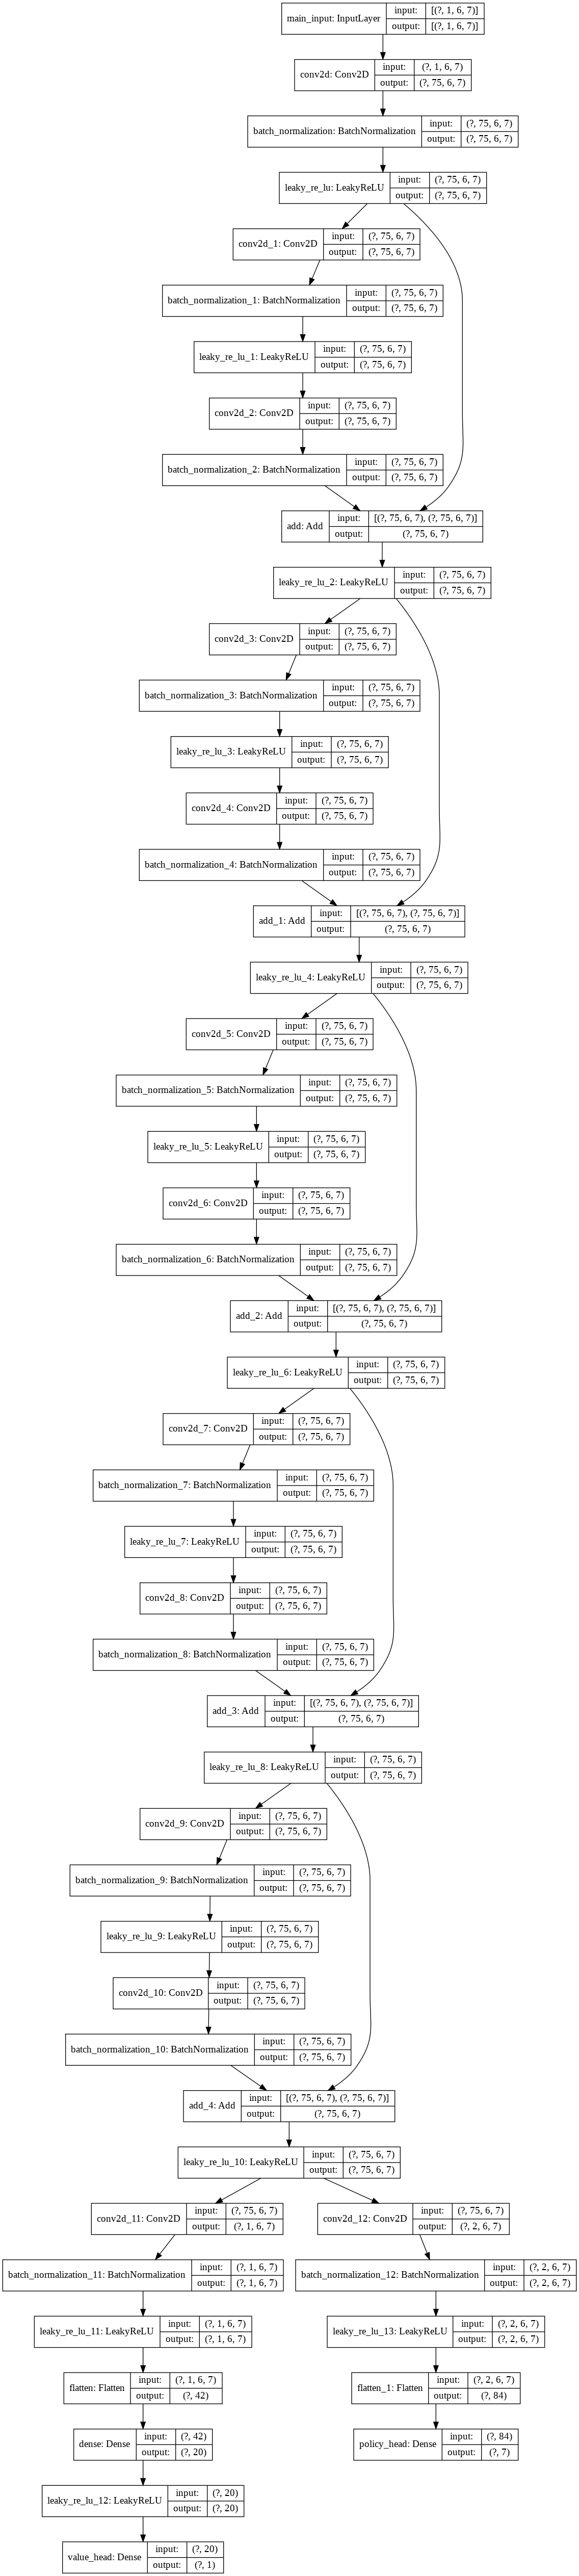

In [ ]:


from tensorflow.keras.utils import plot_model

REG_CONST = 0.0001

HIDDEN_CNN_LAYERS = [
	{'filters':75, 'kernel_size': (4,4)}
	 , {'filters':75, 'kernel_size': (4,4)}
	 , {'filters':75, 'kernel_size': (4,4)}
	 , {'filters':75, 'kernel_size': (4,4)}
	 , {'filters':75, 'kernel_size': (4,4)}
	 , {'filters':75, 'kernel_size': (4,4)}
	]

residual_CNN = Residual_CNN(REG_CONST, (1,) + GRID_SHAPE,   GRID_SHAPE[1], HIDDEN_CNN_LAYERS)

plot_model(residual_CNN.model, show_shapes=True)

# Training: 3 points

In [ ]:

agent_cnn_1 = ## YOUR CODE HERE: instanciate the first agent: as many simulations as you want (not too big, otherwise the computation will be too long)
              ## it must use residual_CNN as a model, cpuct=1, temperature=1, turns_until_deterministic=10



In [ ]:

MOMENTUM = 0.9
LEARNING_RATE = 0.1


In [ ]:

residual_CNN_2 = ## YOUR CODE HERE: instanciate another residual CNN, with the same params as residual_CNN
                  ## Compile it with LEARNING_RATE, MOMENTUM, loss_weights={VALUE_HEAD: 0.5, POLICY_HEAD: 0.5},
                  ## in order to make it trainable
agent_cnn_2 = ## YOUR CODE HERE: instanciate the 2nd agent: same number of simulations as agent_cnn_1 (in order to avoid giving an advantage during the tournaments)
              ## it must use residual_CNN_2 as a model, cpuct=1, temperature=1, turns_until_deterministic=10

In [ ]:
!mkdir models
!mkdir memory

In [ ]:
import pickle

stop_after_2_bad_epochs = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

BATCH_SIZE = 256
EPOCHS = 50

def train_neural_network(agent_cnn_1, agent_cnn_2, agent_version, current_iteration, nb_iterations, nb_games_per_iteration, memory):

  for iteration in range(current_iteration, nb_iterations):

    ## YOUR CODE HERE:
    ##   - feed the memory by playing nb_games_per_iteration games between agent_cnn_1 and itself
    ##   - train agent_cnn_2 on the content of the memory, during EPOCHS epochs, with BATCH_SIZE, stopping after 2 bad epochs.
    ##        don't forget to use state.get_board_for_neural_network() when you create the input of the neural network
    ##        The targets (or labels) can be created with:
    ## training_targets = {VALUE_HEAD: np.array([row['value'] for row in memory.memory])
    ##          , POLICY_HEAD: np.array([row['AV'] for row in memory.memory])} 

    agent_cnn_2.model.write(agent_version, iteration)
    pickle.dump( memory, open("memory/memory_" + str(agent_version) + "_" + str(iteration).zfill(4) + ".p", "wb" ) )

    ## Optionally, you can upload the files on your Google drive automatically, see
    ## https://colab.research.google.com/drive/100Z7aLvJgqJeBoSNwjXUp6gBSZojiRZ1#scrollTo=Nsq6rFIAMSIn for an example
    ## If you do it, upload the latest file found in the folder 'memory' and the latest file found in the folder 'models'

In [ ]:

memory = Memory()
tournament_number = 0
current_iteration = 0

In [ ]:
import glob
import os

latest_saved_iteration = 0
files_in_run_folder = list(glob.iglob("memory/memory*.p"))
if len(files_in_run_folder) > 0:
    latestFile = max(files_in_run_folder,key=os.path.getctime)
    # See https://stackoverflow.com/questions/3368969/find-string-between-two-substrings
    tournament_number = int(latestFile[latestFile.find('_')+len('_'):latestFile.rfind('_')])
    current_iteration = int(latestFile[latestFile.rfind('_')+len('_'):latestFile.rfind('.p')])
    print('LOADING MEMORY for tournament ' + str(tournament_number) + ' and iteration ' + str(current_iteration))
    memory = pickle.load( open( "memory/memory_" + str(tournament_number) + "_" + str(current_iteration).zfill(4) + ".p",   "rb" ) )
    
    print('LOADING MODEL for tournament ' + str(tournament_number) + ' and iteration ' + str(current_iteration))
    agent_cnn_2.model.read(tournament_number, current_iteration)
    agent_cnn_1.model.read(tournament_number, current_iteration)

In [ ]:

SCORING_THRESHOLD = 1.3

while 1:
  ## YOUR CODE HERE:
  ## - train agent_cnn_2 as many times as you want, from the results of the games between agent_cnn_1 and itself
  ## - then play a few games between agent_cnn_1 and agent_cnn_2 and compare the scores

  #    if the score of agent_cnn_2 is more than SCORING_THRESHOLD * the score of agent_cnn_1, update agent_cnn_1 with agent_cnn_2
  if score_agent_2 > score_agent_1 * SCORING_THRESHOLD:
    print( agent_cnn_2.name + " became the best ! Let us copy it into " + agent_cnn_1.name )
    agent_cnn_1.model.model.set_weights(agent_cnn_2.model.model.get_weights())
  else:
    print( "The best is still" + agent_cnn_1.name + ". Maybe next time !")



Iteration: 0: Agent CNN 1 plays 3 times against itself, using the MCTS, in order to create the training set.
012Creation of the training set complete. Now we train the neural network of Agent CNN 2 in order to let it predict the MCTS of Agent CNN 1
Epoch 1/50
1/1 [==============================] - 0s 2ms/step - loss: 1.7161 - value_head_loss: 1.0858 - policy_head_loss: 2.1865
Epoch 2/50
1/1 [==============================] - 0s 1ms/step - loss: 1.2828 - value_head_loss: 0.3020 - policy_head_loss: 2.1037
Epoch 3/50
1/1 [==============================] - 0s 1ms/step - loss: 1.1727 - value_head_loss: 0.2898 - policy_head_loss: 1.8951
Epoch 4/50
1/1 [==============================] - 0s 2ms/step - loss: 1.1086 - value_head_loss: 0.2458 - policy_head_loss: 1.8103
Epoch 5/50
1/1 [==============================] - 0s 1ms/step - loss: 1.0709 - value_head_loss: 0.2066 - policy_head_loss: 1.7734
Epoch 6/50
1/1 [==============================] - 0s 1ms/step - loss: 1.0492 - value_head_loss: 0.183

In [ ]:
# From time to time, interrupt the loop above and play against agent_cnn_1 in order to check how good it is
playerVersusAI(agent_cnn_1)